## Setup

Load Libraries:

In [23]:
import os
import gc
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from typing import Optional, Union


import tensorflow_hub as hub

import torch
from transformers import AutoTokenizer, AutoModel, logging


from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.base import TransformerMixin, BaseEstimator
from sklearn.preprocessing import LabelEncoder, label_binarize
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import GridSearchCV, train_test_split, PredefinedSplit
from sklearn.metrics import (
    f1_score, 
    accuracy_score, 
    confusion_matrix,
    precision_recall_curve,
    ConfusionMatrixDisplay,
    balanced_accuracy_score, 
    average_precision_score
) 

logging.set_verbosity_error() # to avoid warning messages
os.environ["TOKENIZERS_PARALLELISM"] = "false" # set to false to avoid warnings

## Load Data

In [3]:
# Load the data
train_data = pd.read_pickle('./data/train_data.pkl')
test_data = pd.read_pickle('./data/test_data.pkl')

train_data.info()
train_data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5452 entries, 0 to 5451
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   question      5452 non-null   object
 1   category      5452 non-null   object
 2   sub_category  5452 non-null   object
 3   cleaned       5452 non-null   object
 4   wordlengths   5452 non-null   int64 
dtypes: int64(1), object(4)
memory usage: 213.1+ KB


,question,category,sub_category,cleaned,wordlengths
0,How did serfdom develop in and then leave Russ...,DESC,manner,serfdom develop leave russia,10
1,What films featured the character Popeye Doyle ?,ENTY,cremat,film feature character popeye doyle,8
2,How can I find a list of celebrities ' real na...,DESC,manner,list celebrity real name,12
3,What fowl grabs the spotlight after the Chines...,ENTY,animal,fowl grab spotlight chinese year monkey,13
4,What is the full form of .com ?,ABBR,exp,form com,8


## Create Embedding Transformer

We will now create a class for generating embeddings from text data using pre-trained language models. Specifically, we will use two language models:

1. Bidirectional Encoder Representations from Transformers (BERT) Model by Google (read more [here](https://huggingface.co/google-bert/bert-base-uncased)).
2. google/nnlm: Token based text embeddings trained on various Google News datasets (read more [here](https://www.kaggle.com/models/google/nnlm/frameworks/tensorFlow2/variations/en-dim50/versions/1?tfhub-redirect=true)).

In [4]:
class EmbeddingTransformer(BaseEstimator, TransformerMixin):
    """
    A custom transformer for generating embeddings from text data using pre-trained language models.

    Args:
        model_name (str): The name of the pre-trained language model to use for generating embeddings.
                          If "nnlm-en-dim50" is in the model_name, the corresponding TensorFlow Hub model will be used.
                          Otherwise, a Hugging Face Transformers model will be used.
    """

    def __init__(self, model_name: str = "bert-base-uncased"):
        self.model_name = model_name
        self._validate_model_name()

        if "nnlm-en-dim50" in self.model_name:
            self.embed = hub.load("https://www.kaggle.com/models/google/nnlm/frameworks/TensorFlow2/variations/en-dim128/versions/1")
        else:
            self._setup_transformers_model()

    def _validate_model_name(self):
        """Check if the specified model_name is valid."""
        if not isinstance(self.model_name, str):
            raise ValueError("model_name must be a string")

    def _setup_transformers_model(self):
        """Load the Hugging Face Transformers model and set up the appropriate device."""
        self.device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')
        self.tokenizer = AutoTokenizer.from_pretrained(self.model_name)
        self.model = AutoModel.from_pretrained(self.model_name).to(self.device)

    def fit(self, X: Union[pd.Series, pd.DataFrame], y=None):
        """
        Fit the transformer (required for scikit-learn compatibility).

        Args:
            X (Union[pd.Series, pd.DataFrame]): The input data (not used for this transformer).
            y (optional): The target data (not used for this transformer).

        Returns:
            self: The EmbeddingTransformer instance.
        """
        return self

    def transform(self, X: Union[pd.Series, pd.DataFrame]):
        """
        Generate embeddings from input text data using the specified pre-trained language model.

        Args:
            X (Union[pd.Series, pd.DataFrame]): The input text data.

        Returns:
            pd.DataFrame: A Pandas DataFrame containing the generated embeddings.
        """
        self._validate_input_data(X)

        if "nnlm-en-dim50" in self.model_name:
            return self._transform_with_nnlm(X)
        else:
            return self._transform_with_transformers(X)

    def _validate_input_data(self, X: Union[pd.Series, pd.DataFrame]):
        """Check if the input data is valid."""
        if not isinstance(X, (pd.Series, pd.DataFrame)):
            raise ValueError("Input data must be a Pandas Series or DataFrame")

    def _transform_with_nnlm(self, X: Union[pd.Series, pd.DataFrame]):
        """Generate embeddings using the TensorFlow Hub NNLM model."""
        text_data = X.tolist()
        embeddings = self.embed(text_data).numpy()
        return pd.DataFrame(embeddings)

    def _transform_with_transformers(self, X: Union[pd.Series, pd.DataFrame]):
        """Generate embeddings using a Hugging Face Transformers model."""
        batch_text = X.tolist()
        inputs = self.tokenizer.batch_encode_plus(
            batch_text, return_tensors="pt", padding=True, truncation=True, max_length=22
        )
        inputs = {k: v.to(self.device) for k, v in inputs.items()}

        with torch.no_grad():
            outputs = self.model(**inputs)
            embeddings = outputs.last_hidden_state[:, 0, :].cpu().numpy()

        return pd.DataFrame(embeddings)

## create DenseTransformer class to convert sparse matrix to dense matrix
class DenseTransformer(TransformerMixin):

    def fit(self, X, y=None, **fit_params):
        return self

    def transform(self, X, y=None, **fit_params):
        return X.toarray()

## Initialize the vectorizers

In [6]:
# Initialize the vectorizers
default_vectorizers = {
    'CountVectorizer': CountVectorizer(stop_words='english', ngram_range=(1, 2), max_features=1024),
    'TfidfVectorizer': TfidfVectorizer(stop_words='english', ngram_range=(1, 2), max_features=1024),
    'bert-base-uncased': EmbeddingTransformer('bert-base-uncased'),
    'nnlm-en-dim128': EmbeddingTransformer('nnlm-en-dim50')
}

## Create Text Classification Function

In [7]:
def train_and_evaluate_models(
    trad_model,
    parameters,
    X_train,
    y_train,
    X_test,
    y_test,
    vectorizers=None,
    cv: Optional[PredefinedSplit] = None,
):
    results = []
    best_preds_train = {}
    best_preds_test = {}
    current_best = {
        'accuracy': 0,
        'vectorizer': None,
        'model': None,
        'params': None
    }

    if vectorizers is None:
        vectorizers = default_vectorizers

    for name, vectorizer in vectorizers.items():
        print(f'Hyperparameter Tuning for {name}:\n')

        pipeline_steps = [
            ('feature_engineering', vectorizer),
            ('crossvalidate', GridSearchCV(trad_model, parameters,
                                            cv=cv, refit=True, verbose=0, n_jobs=-1))
        ]

        if trad_model.__class__.__name__ == 'GaussianNB' and (name == 'CountVectorizer' or name == 'TfidfVectorizer'):
            pipeline_steps.insert(1, ('to_dense', DenseTransformer()))

        model = Pipeline(steps=pipeline_steps)
        model.fit(X_train, y_train)
        best_model = model.named_steps['crossvalidate'].best_params_

        # Make prediction
        ypred_train = model.predict(X_train)
        ypred_test = model.predict(X_test)

        best_preds_train[vectorizer] = ypred_train
        best_preds_test[vectorizer] = ypred_test

        print('=====================')
        print(f'(1.) Vectorizer = {name}')
        print(f'(2.) Model = {trad_model.__class__.__name__}')
        print(f'(3.) Best Estimator = {best_model}')
        print('=====================\n')

        res = {'Vectorizer': name,
               'Model': trad_model.__class__.__name__,
               'Train ACC': accuracy_score(y_train, ypred_train),
               'Train B ACC': balanced_accuracy_score(y_train, ypred_train),
               'Train F1': f1_score(y_train, ypred_train, average='weighted'),
               'Test ACC': accuracy_score(y_test, ypred_test),
               'Test B ACC': balanced_accuracy_score(y_test, ypred_test),
               'Test F1': f1_score(y_test, ypred_test, average='weighted')}

        results.append(res)

        if res['Test B ACC'] > current_best['accuracy']: ## model selection based on balanced accuracy
            current_best['accuracy'] = res['Test B ACC']
            current_best['vectorizer'] = name
            current_best['model'] = model
            current_best['params'] = best_model

        # Free up memory
        del model
        gc.collect()

    print(f'Hyperparameter Tuning Complete!\n')
    results_df = pd.DataFrame(results)

    return {
        'overall_best_model_result': current_best,
        'metrics_df': results_df,
        'best_preds_train': best_preds_train,
        'best_preds_test': best_preds_test
    }


## Text Classification Pipeline

Text Classification Pipeline

The `train_and_evaluate_models` demonstrates a machine learning pipeline for text classification using various
vectorization techniques and traditional models. The following steps will be followed to use ths code.

1. Data Preparation (this will only be done once):
   - Split the original train data into training and validation sets.
   - Separate the text data (X) and target labels (y) from the input data.

2. Vectorization (defaults to `default_vectorizers`):
   - Define several vectorization techniques, including:
     - CountVectorizer: Converts text data into a matrix of token counts.
     - TfidfVectorizer: Converts text data into a matrix of TF-IDF features.
     - EmbeddingTransformer: Generates embeddings from text data using pre-trained language models
       (e.g., BERT, NNLM).

3. Model Training and Evaluation:
   - Call the `train_and_evaluate_models` function that takes a traditional machine learning model,
     its hyperparameters, and the training/test data as input.
   - The function creates a pipeline with the specified vectorizer, model, and hyperparameters.
   - Grid search is performed to find the best hyperparameters for the model using cross-validation.
   - The pipeline is trained on the training data and evaluated on both the training and test data.
   - Performance metrics (accuracy, balanced accuracy, and F1-score) are calculated and stored.
   - The best model and its hyperparameters are tracked and returned.

4. Usage:
   - We will demonstrate the usage of the `train_and_evaluate_models` function with 
      * Logistic Regression model.
      * Gaussian Naive Bayes, and
      * Extremely Randomized Trees (ExtraTrees).
   - The results, including the best model, performance metrics, and predictions, are stored in a dictionary.

This pipeline can be extended or modified to include additional vectorization techniques, machine learning
models, or preprocessing steps as needed for your specific text classification task.

## Create Validation Splits

I will divide the training data into:

1. Training Set: 90\%
2. Validation Set: 10\%

THe validation set will be used for hyperparameter optimization.

In [8]:
## Get Validation data
train_df, val_df = train_test_split(train_data, test_size=0.1, random_state=42)

## Split X and y
X_train, y_train = train_data['question'], train_data['category']
X_test, y_test = test_data['question'], test_data['category']

split_index = [-1 if x in train_df.index else 0 for x in train_data.index]
pds = PredefinedSplit(test_fold = split_index)

## Logistic Regression

In [9]:
log_reg = LogisticRegression(random_state=42, solver='liblinear', max_iter=int(1e3))
log_reg_params = {
    'penalty': ['l1', 'l2'],
    'C': [0.001, 0.1, 1, 10, 100, 1000],
}

lr_results = train_and_evaluate_models(
    log_reg,
    log_reg_params,
    X_train,
    y_train,
    X_test,
    y_test,
    vectorizers=None,  # Use the default vectorizers
    cv=pds
)

Hyperparameter Tuning for CountVectorizer:



(1.) Vectorizer = CountVectorizer
(2.) Model = LogisticRegression
(3.) Best Estimator = {'C': 1, 'penalty': 'l2'}

Hyperparameter Tuning for TfidfVectorizer:

(1.) Vectorizer = TfidfVectorizer
(2.) Model = LogisticRegression
(3.) Best Estimator = {'C': 1, 'penalty': 'l2'}

Hyperparameter Tuning for bert-base-uncased:

(1.) Vectorizer = bert-base-uncased
(2.) Model = LogisticRegression
(3.) Best Estimator = {'C': 1, 'penalty': 'l2'}

Hyperparameter Tuning for nnlm-en-dim128:

(1.) Vectorizer = nnlm-en-dim128
(2.) Model = LogisticRegression
(3.) Best Estimator = {'C': 1000, 'penalty': 'l1'}

Hyperparameter Tuning Complete!



### Logistic Regression Results

In [10]:
lr_results['metrics_df']

,Vectorizer,Model,Train ACC,Train B ACC,Train F1,Test ACC,Test B ACC,Test F1
0,CountVectorizer,LogisticRegression,0.759721,0.744048,0.762112,0.694,0.692910,0.686102
1,TfidfVectorizer,LogisticRegression,0.743213,0.722536,0.744480,0.704,0.705807,0.694875
2,bert-base-uncased,LogisticRegression,0.942040,0.921940,0.941905,0.926,0.918115,0.924167
3,nnlm-en-dim128,LogisticRegression,0.775862,0.812724,0.775811,0.808,0.818056,0.805953


### Best Model Configuration (Logistic Regression)

In [11]:
print(f"Best Test Balanced Accuracy: {lr_results['overall_best_model_result']['accuracy']:.3f}\n")
print(f"Best Vectorizer: {lr_results['overall_best_model_result']['vectorizer']}\n")

Best Test Balanced Accuracy: 0.918

Best Vectorizer: bert-base-uncased



In [12]:
lr_melt=pd.melt(lr_results['metrics_df'], id_vars=['Vectorizer'], value_vars=['Train ACC', 'Train B ACC', 'Train F1', 'Test ACC', 'Test B ACC', 'Test F1'])
lr_melt.head()

,Vectorizer,variable,value
0,CountVectorizer,Train ACC,0.759721
1,TfidfVectorizer,Train ACC,0.743213
2,bert-base-uncased,Train ACC,0.942040
3,nnlm-en-dim128,Train ACC,0.775862
4,CountVectorizer,Train B ACC,0.744048


### Visualize Results

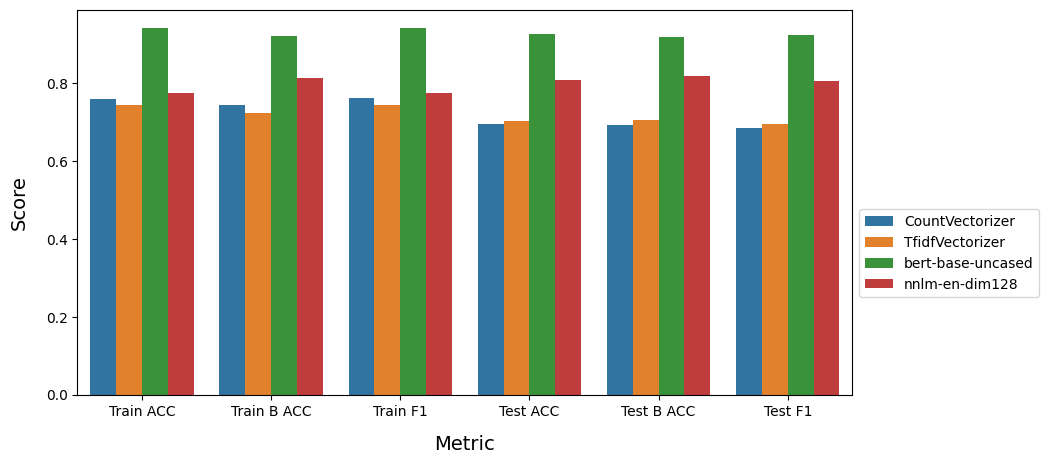

In [13]:
plt.figure(figsize=(10,5))
sns.barplot(x='variable', y='value', hue='Vectorizer', data=lr_melt)
plt.legend(bbox_to_anchor=(1, 0.5))
plt.xlabel("Metric", labelpad=12, fontsize=14)
plt.ylabel("Score", labelpad=12, fontsize=14)
plt.show()

In [14]:
def plot_confusion_matrices(lr_results, y_test, default_vectorizers, titles=None):
    """
    Plots up to four confusion matrices for the results contained in lr_results dictionary.
    
    Parameters:
    - lr_results: A dictionary containing logistic regression results, including 'best_preds_test' and 'overall_best_model_result'.
    - y_test: The true labels against which to compare the predictions.
    - default_vectorizers: A dictionary to derive titles from its keys, if not provided.
    - titles: Optional. A list of titles for each confusion matrix. If not provided, will use the keys from default_vectorizers.
    """
    if titles is None:
        titles = list(default_vectorizers.keys())
    
    total_matrices = len(lr_results["best_preds_test"].keys())
    
    if total_matrices > 4:
        print("Warning: The code is set to handle only 4 confusion matrices. Adjust the subplot for more.")
        total_matrices = 4  # Limiting to 4 to prevent errors in the current setup

    # Adjust the figsize to change the overall size of each subplot
    fig, axarr = plt.subplots(2, 2, figsize=(8, 8))
    
    for key in range(total_matrices):
        ax = axarr[key//2, key%2]  # Access the ax object in a 2x2 fashion
        idx = list(lr_results["best_preds_test"].keys())[key]
        cm = confusion_matrix(y_true=y_test, y_pred=lr_results["best_preds_test"][idx])
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=lr_results['overall_best_model_result']['model'].classes_)

        # Specify the ax parameter and adjust the color map, reduce the text size inside confusion matrix using colorbar
        disp.plot(cmap='Blues', ax=ax, colorbar=False)  # Setting colorbar to False to not display the color bar

        # Reduce the size of the numbers inside the confusion matrix
        for texts in disp.text_:
            for text in texts:
                text.set_size(10)

        # Adjusting title and label sizes
        ax.set_title(f'Confusion Matrix for {titles[key]}', fontsize=10)
        ax.set_xlabel('Predicted label', fontsize=9)
        ax.set_ylabel('True label', fontsize=9)
        ax.tick_params(axis='both', which='major', labelsize=8)

    # Show the plot after constructing all subplots
    plt.tight_layout()
    plt.show()


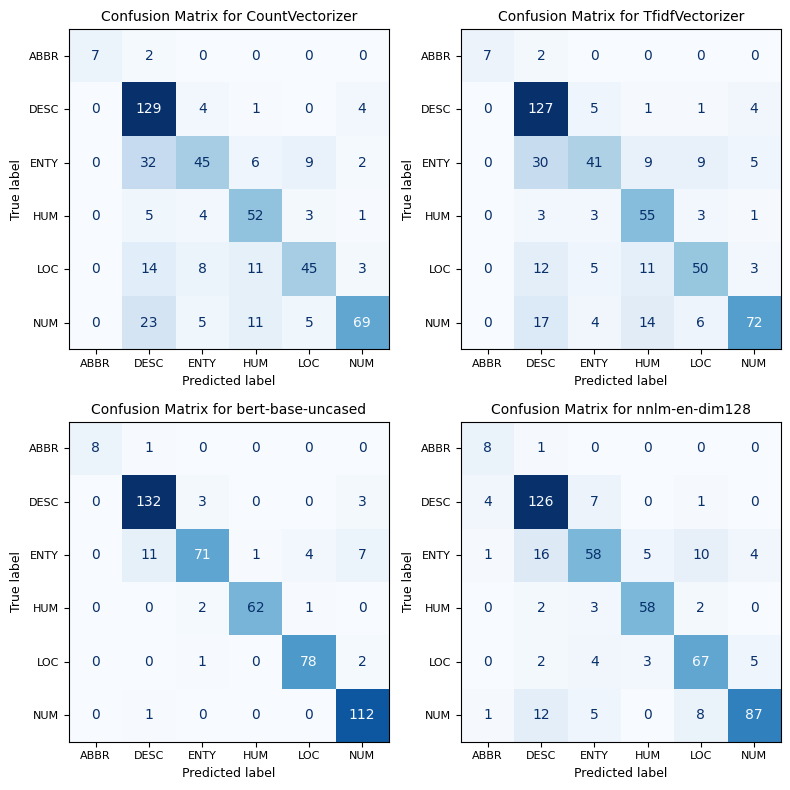

In [15]:
plot_confusion_matrices(lr_results, y_test, default_vectorizers)

In [16]:
# Save the results to a CSV file
os.makedirs('result', exist_ok=True)

lr_results['metrics_df'].to_csv('result/lr_results.csv', index=False)

## Gaussian Naive Bayes

In [17]:
nb_class = GaussianNB()
nb_params= {
    'var_smoothing': [
        1e-9, 1e-8, 1e-7, 1e-6, 
        1e-5, 1e-4, 1e-3, 1e-2, 1e-1
    ]
}


nb_results = train_and_evaluate_models(
    nb_class,
    nb_params,
    X_train,
    y_train,
    X_test,
    y_test,
    vectorizers=None,  # Use the default vectorizers
    cv=pds
)

Hyperparameter Tuning for CountVectorizer:

(1.) Vectorizer = CountVectorizer
(2.) Model = GaussianNB
(3.) Best Estimator = {'var_smoothing': 0.01}

Hyperparameter Tuning for TfidfVectorizer:

(1.) Vectorizer = TfidfVectorizer
(2.) Model = GaussianNB
(3.) Best Estimator = {'var_smoothing': 0.01}

Hyperparameter Tuning for bert-base-uncased:

(1.) Vectorizer = bert-base-uncased
(2.) Model = GaussianNB
(3.) Best Estimator = {'var_smoothing': 1e-09}

Hyperparameter Tuning for nnlm-en-dim128:

(1.) Vectorizer = nnlm-en-dim128
(2.) Model = GaussianNB
(3.) Best Estimator = {'var_smoothing': 1e-09}

Hyperparameter Tuning Complete!



In [18]:
nb_results['metrics_df']

,Vectorizer,Model,Train ACC,Train B ACC,Train F1,Test ACC,Test B ACC,Test F1
0,CountVectorizer,GaussianNB,0.617572,0.688672,0.647323,0.350,0.475446,0.374211
1,TfidfVectorizer,GaussianNB,0.643067,0.709821,0.673273,0.382,0.512752,0.402177
2,bert-base-uncased,GaussianNB,0.622524,0.675442,0.615400,0.662,0.700785,0.628506
3,nnlm-en-dim128,GaussianNB,0.634263,0.664092,0.633256,0.654,0.717778,0.651463


In [19]:
print(f"Best Test Balanced Accuracy: {nb_results['overall_best_model_result']['accuracy']:.3f}\n")
print(f"Best Vectorizer: {nb_results['overall_best_model_result']['vectorizer']}\n")

Best Test Balanced Accuracy: 0.718

Best Vectorizer: nnlm-en-dim128



In [20]:
nb_melt=pd.melt(nb_results['metrics_df'], id_vars=['Vectorizer'], value_vars=['Train ACC', 'Train B ACC', 'Train F1', 'Test ACC', 'Test B ACC', 'Test F1'])
nb_melt.head()

,Vectorizer,variable,value
0,CountVectorizer,Train ACC,0.617572
1,TfidfVectorizer,Train ACC,0.643067
2,bert-base-uncased,Train ACC,0.622524
3,nnlm-en-dim128,Train ACC,0.634263
4,CountVectorizer,Train B ACC,0.688672


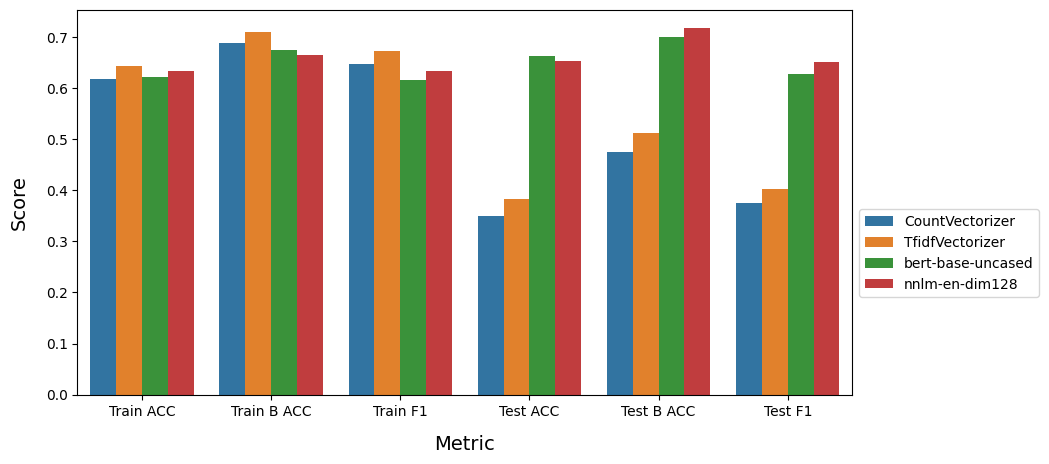

In [21]:
plt.figure(figsize=(10,5))
sns.barplot(x='variable', y='value', hue='Vectorizer', data=nb_melt)
plt.legend(bbox_to_anchor=(1, 0.5))
plt.xlabel("Metric", labelpad=12, fontsize=14)
plt.ylabel("Score", labelpad=12, fontsize=14)
plt.show()

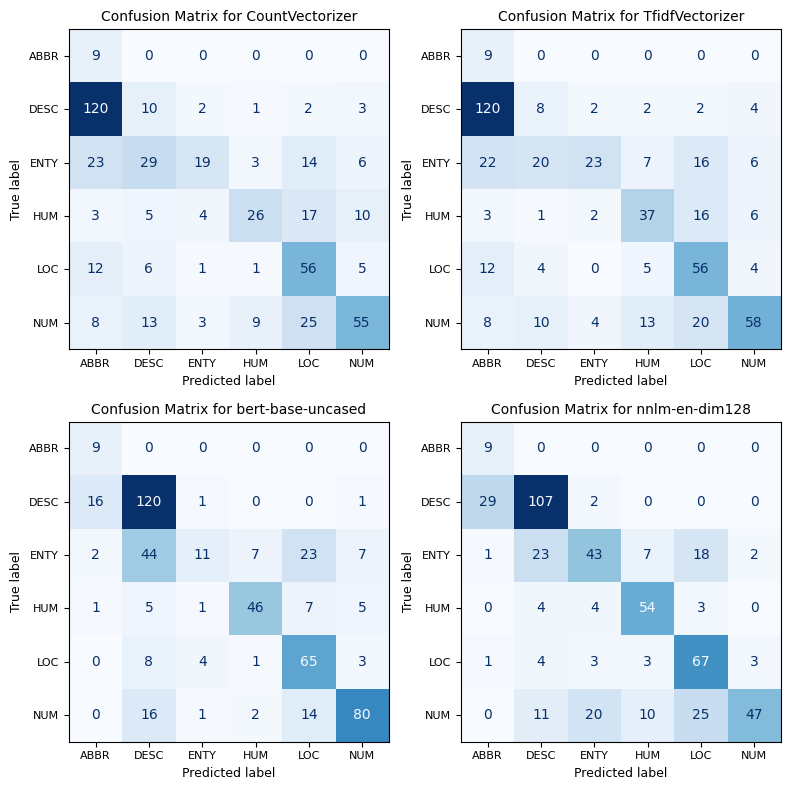

In [22]:
plot_confusion_matrices(nb_results, y_test, default_vectorizers)

## ExtraTrees Classifier

In [ ]:
et_model= ExtraTreesClassifier(n_jobs=-1, random_state=42)
et_params = {
    'criterion': ['gini', 'entropy'],
    'n_estimators': [100, 300, 500],
    'max_features': [None, 'sqrt', 'log2'],
    'max_depth': [None, 5, 10]
}

rf_results = train_and_evaluate_models(model, parameters)